##Data https://www.kaggle.com/datasets/balabaskar/warren-buffet-letters-to-investors-1977-2021/data

# Final project code

## install requirements

In [1]:
!pip install -r requirements.txt

transformers datasets rouge-score torch pandas nltk gensim wordcloud matplotlib scikit-learn

## imports

In [2]:
import os
import json
import pandas as pd
import torch
import nltk
import textwrap
import re
import string
from nltk.corpus import stopwords
from tqdm import tqdm
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation)

## Load .txt Letters into a DataFrame

In [7]:
def load_letters_from_folder(folder_path):
    data = []
    for fname in sorted(os.listdir(folder_path)):
        if fname.endswith(".txt"):
            match = re.search(r'(\d{4})', fname)
            if match:
                year = int(match.group(1))
                file_path = os.path.join(folder_path, fname)

                # Try reading with utf-8, then fallback
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                except UnicodeDecodeError:
                    with open(file_path, 'r', encoding='windows-1252') as f:
                        content = f.read()

                data.append({'year': year, 'letter_text': content})
            else:
                print(f"Skipping file (no year found): {fname}")
    return pd.DataFrame(data)

In [8]:
letters_df = load_letters_from_folder('data')  # Update path

## Summarization with BART

In [9]:
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
def chunk_text(text, max_tokens=800):
    return textwrap.wrap(text, max_tokens)

def summarize_text(text, max_length=100, min_length=50):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU
    summary_ids = model.generate(**inputs, max_length=max_length, min_length=min_length, do_sample=False)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [11]:
# folder for saving individual summaries
os.makedirs("summaries_temp", exist_ok=True)

summaries = []
for _, row in tqdm(letters_df.iterrows(), total=len(letters_df)):
    year = row['year']
    temp_path = f"summaries_temp/{year}.json"

    # Skip if already saved
    if os.path.exists(temp_path):
        with open(temp_path, "r") as f:
            summary = json.load(f)["summary"]
        summaries.append({"year": year, "summary": summary})
        continue

    # Generate summary
    chunks = chunk_text(row['letter_text'])
    full_summary = " ".join([summarize_text(c) for c in chunks])
    summaries.append({"year": year, "summary": full_summary})

    # Save individual dummary right away
    with open(temp_path, "w") as f:
        json.dump({"summary": full_summary}, f)

# save full summary df to csv
summary_df = pd.DataFrame(summaries).sort_values("year")
summary_df.to_csv("buffett_letter_summaries.csv", index=False)
print("All summaries saved to buffett_letter_summaries.csv")


100%|██████████| 45/45 [00:00<00:00, 3075.15it/s]

All summaries saved to buffett_letter_summaries.csv


##  Evaluate with ROUGE

In [12]:
# Check if ROUGE results already exist
if os.path.exists("buffett_rouge_scores.csv"):
    print("ROUGE scores already calculated. Skipping evaluation.")
    rouge_df = pd.read_csv("buffett_rouge_scores.csv")
    print(rouge_df.tail(1))  # Show the average row
else:
    # Load summaries
    summary_df = pd.read_csv("buffett_letter_summaries.csv")
    merged_df = pd.merge(letters_df, summary_df, on="year")

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_data = []

    for _, row in merged_df.iterrows():
        ref = row["letter_text"]
        gen = row["summary"]
        year = row["year"]
        scores = scorer.score(ref, gen)

        rouge_data.append({
            "year": year,
            "rouge1": scores['rouge1'].fmeasure,
            "rouge2": scores['rouge2'].fmeasure,
            "rougeL": scores['rougeL'].fmeasure
        })

        print(f"Year {year} - ROUGE-1: {scores['rouge1'].fmeasure:.4f}, ROUGE-2: {scores['rouge2'].fmeasure:.4f}, ROUGE-L: {scores['rougeL'].fmeasure:.4f}")

    rouge_df = pd.DataFrame(rouge_data).sort_values("year")

    # Add average row
    avg_row = {
        "year": "Average",
        "rouge1": rouge_df["rouge1"].mean(),
        "rouge2": rouge_df["rouge2"].mean(),
        "rougeL": rouge_df["rougeL"].mean()
    }
    rouge_df = pd.concat([rouge_df, pd.DataFrame([avg_row])], ignore_index=True)

    # Save to CSV
    rouge_df.to_csv("buffett_rouge_scores.csv", index=False)

    print("\nROUGE scores saved to buffett_rouge_scores.csv")
    print(f"\nAverage ROUGE Scores Across All Letters:")
    print(f"ROUGE-1: {avg_row['rouge1']:.4f}")
    print(f"ROUGE-2: {avg_row['rouge2']:.4f}")
    print(f"ROUGE-L: {avg_row['rougeL']:.4f}")


ROUGE scores already calculated. Skipping evaluation.
       year    rouge1    rouge2    rougeL
45  Average  0.558631  0.523956  0.536254


## Topic Modeling with LDA (Comparison to BART)

In [13]:
def prepare_corpus(texts):
    custom_stopwords = {"berkshire", "hathaway", "would", "year", "years", "com",
    "berk", "shire", "’", "“", "”", "--", "–", "ok"}
    stop_words = set(stopwords.words("english")).union(custom_stopwords)
    punctuation = set(string.punctuation)

    tokenized = []
    for text in texts:
        words = word_tokenize(text.lower())
        words = [w for w in words if w.isalpha() and len(w) > 2 and w not in stop_words]
        tokenized.append(words)

    dictionary = corpora.Dictionary(tokenized)
    dictionary.filter_extremes(no_below=2, no_above=0.9)
    corpus = [dictionary.doc2bow(text) for text in tokenized]
    return dictionary, corpus


In [14]:
dictionary, corpus = prepare_corpus(letters_df["letter_text"])
lda_model = models.LdaModel(
    corpus,
    num_topics=4,
    id2word=dictionary,
    passes=25,
    iterations=300,
    random_state=3
)

topics = lda_model.print_topics(num_words=10)
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {topic}")

Topic 1: (0, '0.009*"billion" + 0.004*"float" + 0.004*"clayton" + 0.003*"huge" + 0.003*"ceo" + 0.003*"america" + 0.002*"directors" + 0.002*"today" + 0.002*"acquisitions" + 0.002*"millions"')
Topic 2: (1, '0.003*"bonds" + 0.003*"inflation" + 0.003*"ratio" + 0.003*"blue" + 0.003*"chip" + 0.003*"retained" + 0.003*"intrinsic" + 0.003*"goodwill" + 0.003*"per" + 0.003*"upon"')
Topic 3: (2, '0.010*"billion" + 0.006*"float" + 0.003*"huge" + 0.003*"intrinsic" + 0.003*"country" + 0.002*"contracts" + 0.002*"ceo" + 0.002*"bnsf" + 0.002*"millions" + 0.002*"midamerican"')
Topic 4: (3, '0.003*"float" + 0.003*"ceo" + 0.003*"billion" + 0.002*"zero" + 0.002*"bonds" + 0.002*"contributions" + 0.002*"reinsurance" + 0.002*"instead" + 0.002*"directors" + 0.002*"intrinsic"')


#### Topic modeling interpretation

| Topic # | Label                                | Representative Words                                     |
|---------|--------------------------------------|----------------------------------------------------------|
| 1       | Scale, Leadership & Acquisitions | `"billion"`, `"clayton"`, `"ceo"`, `"acquisitions"`      |
| 2       | Valuation & Investment Philosophy | `"intrinsic"`, `"ratio"`, `"bonds"`, `"blue chip"`       |
| 3       | Subsidiaries & Macroeconomic Insights | `"bnsf"`, `"midamerican"`, `"country"`, `"contracts"` |
| 4       | Insurance & Capital Allocation    | `"float"`, `"reinsurance"`, `"contributions"`, `"bonds"` |

In [15]:
letter_topics = []
for i, bow in enumerate(corpus):
    topics = lda_model.get_document_topics(bow)
    top_topic = max(topics, key=lambda x: x[1])[0]
    letter_topics.append({"year": letters_df.iloc[i]["year"], "dominant_topic": top_topic})

topic_df = pd.DataFrame(letter_topics)

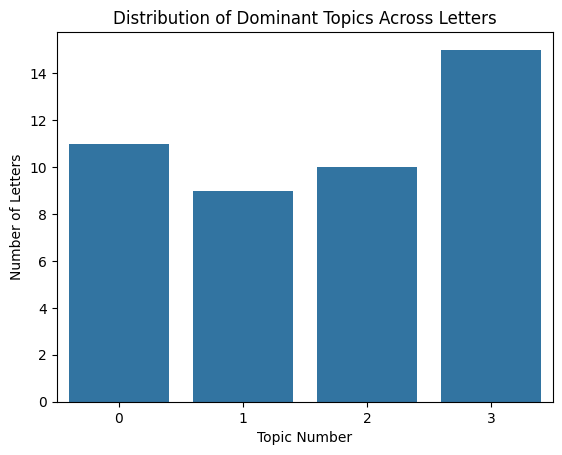

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="dominant_topic", data=topic_df)
plt.title("Distribution of Dominant Topics Across Letters")
plt.xlabel("Topic Number")
plt.ylabel("Number of Letters")
plt.show()

## Word cloud and Top Words by Decade

In [17]:
#Merge in the summaries only if not already present
if "summary" not in letters_df.columns:
    summary_df = pd.read_csv("buffett_letter_summaries.csv")
    letters_df = pd.merge(letters_df, summary_df, on="year")

def get_top_words(df, start_year, end_year, n=10):
    subset = df[(df["year"] >= start_year) & (df["year"] <= end_year)]
    all_text = " ".join(subset["summary"].tolist()).lower()
    words = word_tokenize(all_text)
    custom_stopwords = {"berkshire", "hathaway", "would", "year", "years", "com", "berk", "shire", "’", "“", "”", "--", "–", "ok"}
    stop_words = set(stopwords.words("english")).union(custom_stopwords)
    # Filter out stopwords, punctuation, and digits
    clean_words = [w for w in words if w.isalpha() and len(w) > 2 and w not in stop_words and w not in punctuation]
    freq = Counter(clean_words)
    top_words = freq.most_common(n)

    return pd.DataFrame(top_words, columns=["word", "frequency"])

In [18]:
# Run for each decade
decades = [(1980, 1989), (1990, 1999), (2000, 2009), (2010, 2021)]

for start, end in decades:
    print(f"\nTop words from {start}-{end}:")
    df_top = get_top_words(letters_df, start, end)
    print(df_top)


Top words from 1980-1989:
         word  frequency
0    business        327
1    earnings        216
2     million        175
3       value        166
4  businesses        137
5   insurance        117
6     company        113
7     capital        108
8      market        108
9   companies        107

Top words from 1990-1999:
         word  frequency
0    business        249
1    earnings        212
2       value        188
3     company        188
4     million        178
5       stock        126
6        last        112
7         one         99
8  businesses         92
9      shares         88

Top words from 2000-2009:
        word  frequency
0    company        156
1   business        155
2    million        154
3   earnings        145
4    billion        124
5      value        122
6       last        120
7        one         97
8  insurance         90
9        may         82

Top words from 2010-2021:
         word  frequency
0     billion        241
1    earnings        211
2  

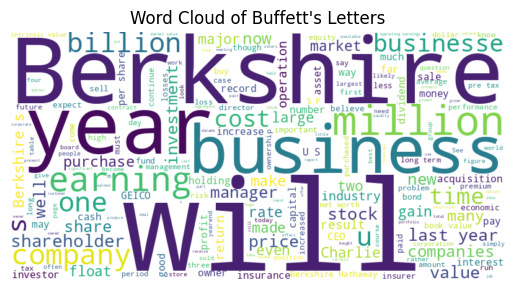

In [19]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", random_state=42).generate(" ".join(letters_df["summary"]))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Buffett's Letters")
plt.show()

## Sentiment Trend Analysis

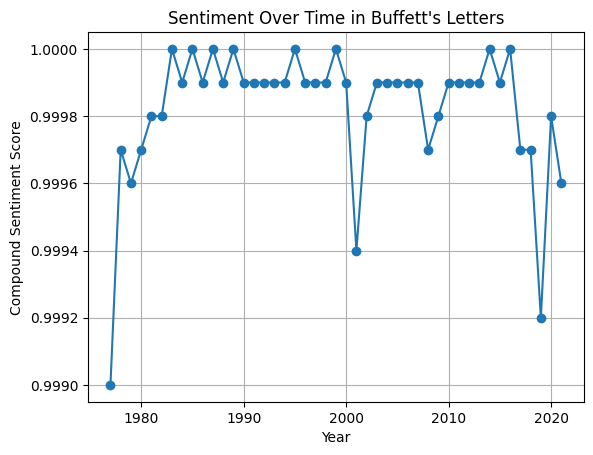

In [20]:
sia = SentimentIntensityAnalyzer()
letters_df["sentiment"] = letters_df["summary"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Plot sentiment trend
plt.plot(letters_df["year"], letters_df["sentiment"], marker='o')
plt.title("Sentiment Over Time in Buffett's Letters")
plt.xlabel("Year")
plt.ylabel("Compound Sentiment Score")
plt.grid(True)
plt.show()